## 关于学生叙述能力的差异分析(宏观叙事-情境模型)

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, tukey_hsd, levene, shapiro
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

def load_and_prepare_data():
    """加载和准备数据"""
    # 读取数据
    data = pd.read_csv('../pre_data/宏观叙事-情境模型-grade.csv')
    
    # 将年级标签转换为更易理解的名称
    grade_mapping = {1: '高一', 2: '高二', 3: '高三'}
    data['年级名称'] = data['年级'].map(grade_mapping)
    
    # 按年级分组数据
    grade_groups = {grade: group for grade, group in data.groupby('年级名称')}
    
    return data, grade_groups
data, grade_groups = load_and_prepare_data()

In [9]:
def descriptive_statistics_situation_model(data, grade_groups):
    """宏观叙事情境模型描述性统计分析"""
    print("=" * 80)
    print("宏观叙事情境模型描述性统计分析报告")
    print("=" * 80)
    
    # 1. 基本统计信息
    print("\n1. 数据基本信息：")
    print(f"总样本数：{len(data)}")
    print(f"年级分布：\n{data['年级名称'].value_counts().sort_index()}")
    
    # 2. 各年级描述性统计
    print("\n2. 各年级描述性统计：")
    
    indicators = {
        '因果衔接': '因果衔接-SMCAUSr-64',
        '意图衔接': '意图衔接-SMINTEr-65',
        '时体衔接': '时体衔接-SMTEMP-68'
    }
    
    for grade_name in ['高一', '高二', '高三']:
        print(f"\n{grade_name}：")
        print(f"  样本数：{len(grade_groups[grade_name])}")
        for indicator_name, indicator_col in indicators.items():
            values = grade_groups[grade_name][indicator_col]
            print(f"  {indicator_name} - 均值：{values.mean():.3f}, 标准差：{values.std():.3f}")
    
    # 3. 正态性检验
    print("\n3. 正态性检验：")
    
    for grade_name in ['高一', '高二', '高三']:
        print(f"\n{grade_name}：")
        for indicator_name, indicator_col in indicators.items():
            values = grade_groups[grade_name][indicator_col]
            stat, p_value = shapiro(values)
            normality = "正态分布" if p_value > 0.05 else "非正态分布"
            print(f"  {indicator_name} - Shapiro-Wilk检验：W={stat:.4f}, p={p_value:.4f} ({normality})")
    
    # 4. 方差齐性检验
    print("\n4. 方差齐性检验：")
    
    for indicator_name, indicator_col in indicators.items():
        grade1_data = grade_groups['高一'][indicator_col]
        grade2_data = grade_groups['高二'][indicator_col]
        grade3_data = grade_groups['高三'][indicator_col]
        
        stat, p_value = levene(grade1_data, grade2_data, grade3_data)
        homogeneity = "方差齐性" if p_value > 0.05 else "方差非齐性"
        print(f"{indicator_name} - Levene检验：F={stat:.4f}, p={p_value:.4f} ({homogeneity})")
    
    # 5. 年级间比较分析
    print("\n5. 年级间比较分析：")
    
    for indicator_name, indicator_col in indicators.items():
        print(f"\n{indicator_name}年级间比较：")
        
        grade1_data = grade_groups['高一'][indicator_col]
        grade2_data = grade_groups['高二'][indicator_col]
        grade3_data = grade_groups['高三'][indicator_col]
        
        # 单因素方差分析
        f_stat, p_value = f_oneway(grade1_data, grade2_data, grade3_data)
        print(f"  单因素方差分析：F={f_stat:.4f}, p={p_value:.4f}")
        
        if p_value < 0.05:
            print("  结果：存在显著性差异")
            
            # Tukey HSD事后检验
            tukey_result = tukey_hsd(grade1_data, grade2_data, grade3_data)
            print("  Tukey HSD事后检验结果：")
            print(f"    高一 vs 高二：p={tukey_result.pvalue[0][0]:.4f}")
            print(f"    高一 vs 高三：p={tukey_result.pvalue[0][1]:.4f}")
            print(f"    高二 vs 高三：p={tukey_result.pvalue[1][2]:.4f}")
        else:
            print("  结果：无显著性差异")
    
    # 6. 年级内比较分析
    print("\n6. 年级内比较分析：")
    
    for grade_name in ['高一', '高二', '高三']:
        print(f"\n{grade_name}内部差异分析：")
        
        # 计算各指标组的变异系数
        cv_dict = {}
        for indicator_name, indicator_col in indicators.items():
            values = grade_groups[grade_name][indicator_col]
            cv = (values.std() / values.mean()) * 100
            cv_dict[indicator_name] = cv
        
        # 按变异系数排序
        sorted_cv = sorted(cv_dict.items(), key=lambda x: x[1], reverse=True)
        
        print("  各组指标平均变异系数（从大到小排序）：")
        for indicator_name, cv in sorted_cv:
            print(f"    {indicator_name}指标：{cv:.2f}%")
        
        # 找出差异程度最大的指标组
        max_cv_indicator, max_cv = sorted_cv[0]
        print(f"  差异程度最大的指标组：{max_cv_indicator}指标（平均变异系数：{max_cv:.2f}%）")
        print(f"  该指标组是影响{grade_name}阶段能力发展的关键因素")
        
        # 显示该指标组内部各指标的变异系数
        print(f"  {max_cv_indicator}指标内部各指标变异系数：")
        for indicator_name, indicator_col in indicators.items():
            if indicator_name == max_cv_indicator:
                values = grade_groups[grade_name][indicator_col]
                cv = (values.std() / values.mean()) * 100
                print(f"    {indicator_col}：{cv:.2f}%")

# ... existing code ...

def create_situation_model_boxplots(data, grade_groups, save_path='../res/宏观叙事情境模型箱线图比较.png'):
    """创建宏观叙事情境模型箱线图比较 - 采用高级美观的seaborn风格"""
    print("生成宏观叙事情境模型箱线图...")
    
    # 设置全局风格
    sns.set_theme(style="whitegrid", font="SimHei", rc={
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "axes.titleweight": "bold"
    })
    plt.rcParams['axes.unicode_minus'] = False

    # 设置颜色主题
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    grade_names = ['高一', '高二', '高三']
    
    # 定义指标
    indicators = {
        '因果衔接': '因果衔接-SMCAUSr-64',
        '意图衔接': '意图衔接-SMINTEr-65',
        '时体衔接': '时体衔接-SMTEMP-68'
    }
    
    # 构造DataFrame用于seaborn
    df_list = []
    for indicator_name, indicator_col in indicators.items():
        for grade in grade_names:
            grade_data = grade_groups[grade][indicator_col]
            df_temp = pd.DataFrame({
                '年级': [grade] * len(grade_data),
                '指标值': grade_data,
                '指标类型': [indicator_name] * len(grade_data)
            })
            df_list.append(df_temp)
    
    df_combined = pd.concat(df_list, ignore_index=True)
    
    # 创建图形
    fig, axes = plt.subplots(1, 3, figsize=(18, 8), dpi=120, constrained_layout=True)
    
    for i, (indicator_name, indicator_col) in enumerate(indicators.items()):
        ax = axes[i]
        df_indicator = df_combined[df_combined['指标类型'] == indicator_name]
        
        # 小提琴图+箱线图
        sns.violinplot(
            x='年级', y='指标值', data=df_indicator, ax=ax,
            inner=None, palette=colors, linewidth=0, alpha=0.18
        )
        sns.boxplot(
            x='年级', y='指标值', data=df_indicator, ax=ax,
            width=0.25, palette=colors, boxprops=dict(alpha=0.7)
        )
        
        # 均值点
        means = df_indicator.groupby('年级')['指标值'].mean()
        ax.scatter(range(len(grade_names)), means, color='#E74C3C', s=120, marker='D', 
                  edgecolor='white', zorder=10, label='均值')
        
        # 美化
        ax.set_title(f'{indicator_name}年级间分布对比', fontsize=20, fontweight='bold', color='#222')
        ax.set_xlabel('年级', fontsize=16, fontweight='bold')
        ax.set_ylabel('指标值', fontsize=16, fontweight='bold')
        ax.grid(axis='y', linestyle='--', alpha=0.25)
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # 自定义图例
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    legend_elements = [
        Patch(facecolor='#2E86AB', edgecolor='#2E86AB', label='高一', alpha=0.7),
        Patch(facecolor='#A23B72', edgecolor='#A23B72', label='高二', alpha=0.7),
        Patch(facecolor='#F18F01', edgecolor='#F18F01', label='高三', alpha=0.7),
        Line2D([0], [0], marker='D', color='w', label='均值', markerfacecolor='#E74C3C', 
               markeredgecolor='white', markersize=12)
    ]
    
    for ax in axes:
        ax.legend(handles=legend_elements, loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    # 去除多余边距
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"箱线图已保存为: {save_path}")

def create_situation_model_heatmap(data, grade_groups, save_path='../res/宏观叙事情境模型变异系数热力图.png'):
    """创建宏观叙事情境模型变异系数热力图"""
    print("生成宏观叙事情境模型变异系数热力图...")
    
    # 设置全局风格
    sns.set_theme(style="whitegrid", font="SimHei", rc={
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "axes.titleweight": "bold"
    })
    plt.rcParams['axes.unicode_minus'] = False
    
    # 定义指标
    indicators = {
        '因果衔接': '因果衔接-SMCAUSr-64',
        '意图衔接': '意图衔接-SMINTEr-65',
        '时体衔接': '时体衔接-SMTEMP-68'
    }
    
    grade_names = ['高一', '高二', '高三']
    
    # 计算各年级各指标的变异系数
    cv_matrix = []
    for grade in grade_names:
        grade_data = grade_groups[grade]
        cv_row = []
        for name, col in indicators.items():
            cv = grade_data[col].std() / grade_data[col].mean() * 100
            cv_row.append(cv)
        cv_matrix.append(cv_row)
    
    cv_matrix = np.array(cv_matrix)
    
    # 创建图形
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=120, constrained_layout=True,layout='constrained')
    
    # 创建热力图
    im = sns.heatmap(
        cv_matrix, 
        annot=True, 
        cmap='RdYlBu_r', 
        center=cv_matrix.mean(),
        square=True, 
        linewidths=2, 
        cbar_kws={"shrink": .8, "label": "变异系数 (%)"},
        ax=ax, 
        fmt='.1f', 
        annot_kws={'size': 14, 'weight': 'bold'},
        xticklabels=list(indicators.keys()),
        yticklabels=grade_names
    )
    
    # 设置标题和标签
    ax.set_title('各年级各指标变异系数热力图', fontsize=20, fontweight='bold', color='#222', pad=20)
    ax.set_xlabel('指标', fontsize=16, fontweight='bold', color='#222')
    ax.set_ylabel('年级', fontsize=16, fontweight='bold', color='#222')
    
    # 美化坐标轴
    ax.tick_params(axis='both', which='major', labelsize=12, labelcolor='#222')
    
    # 旋转x轴标签以提高可读性
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # 调整布局
    #plt.tight_layout()
    
    # 保存图片
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"变异系数热力图已保存为: {save_path}")

def create_situation_model_visualizations(data, grade_groups):
    """创建宏观叙事情境模型可视化图表"""
    print("生成宏观叙事情境模型可视化图表...")
    
    # 创建箱线图
    create_situation_model_boxplots(data, grade_groups)
    
    # 创建变异系数热力图
    create_situation_model_heatmap(data, grade_groups)


宏观叙事情境模型描述性统计分析报告

1. 数据基本信息：
总样本数：300
年级分布：
年级名称
高一    100
高三    100
高二    100
Name: count, dtype: int64

2. 各年级描述性统计：

高一：
  样本数：100
  因果衔接 - 均值：0.319, 标准差：0.223
  意图衔接 - 均值：0.326, 标准差：0.192
  时体衔接 - 均值：0.856, 标准差：0.092

高二：
  样本数：100
  因果衔接 - 均值：0.256, 标准差：0.234
  意图衔接 - 均值：0.391, 标准差：0.245
  时体衔接 - 均值：0.881, 标准差：0.076

高三：
  样本数：100
  因果衔接 - 均值：0.255, 标准差：0.222
  意图衔接 - 均值：0.524, 标准差：0.448
  时体衔接 - 均值：0.876, 标准差：0.088

3. 正态性检验：

高一：
  因果衔接 - Shapiro-Wilk检验：W=0.9346, p=0.0001 (非正态分布)
  意图衔接 - Shapiro-Wilk检验：W=0.9691, p=0.0188 (非正态分布)
  时体衔接 - Shapiro-Wilk检验：W=0.9503, p=0.0009 (非正态分布)

高二：
  因果衔接 - Shapiro-Wilk检验：W=0.8671, p=0.0000 (非正态分布)
  意图衔接 - Shapiro-Wilk检验：W=0.9678, p=0.0151 (非正态分布)
  时体衔接 - Shapiro-Wilk检验：W=0.9649, p=0.0092 (非正态分布)

高三：
  因果衔接 - Shapiro-Wilk检验：W=0.8131, p=0.0000 (非正态分布)
  意图衔接 - Shapiro-Wilk检验：W=0.7936, p=0.0000 (非正态分布)
  时体衔接 - Shapiro-Wilk检验：W=0.9571, p=0.0025 (非正态分布)

4. 方差齐性检验：
因果衔接 - Levene检验：F=0.7513, p=0.4727 (方差齐性)
意图衔接 - Levene检验：F=9.0005, p=0.0002 

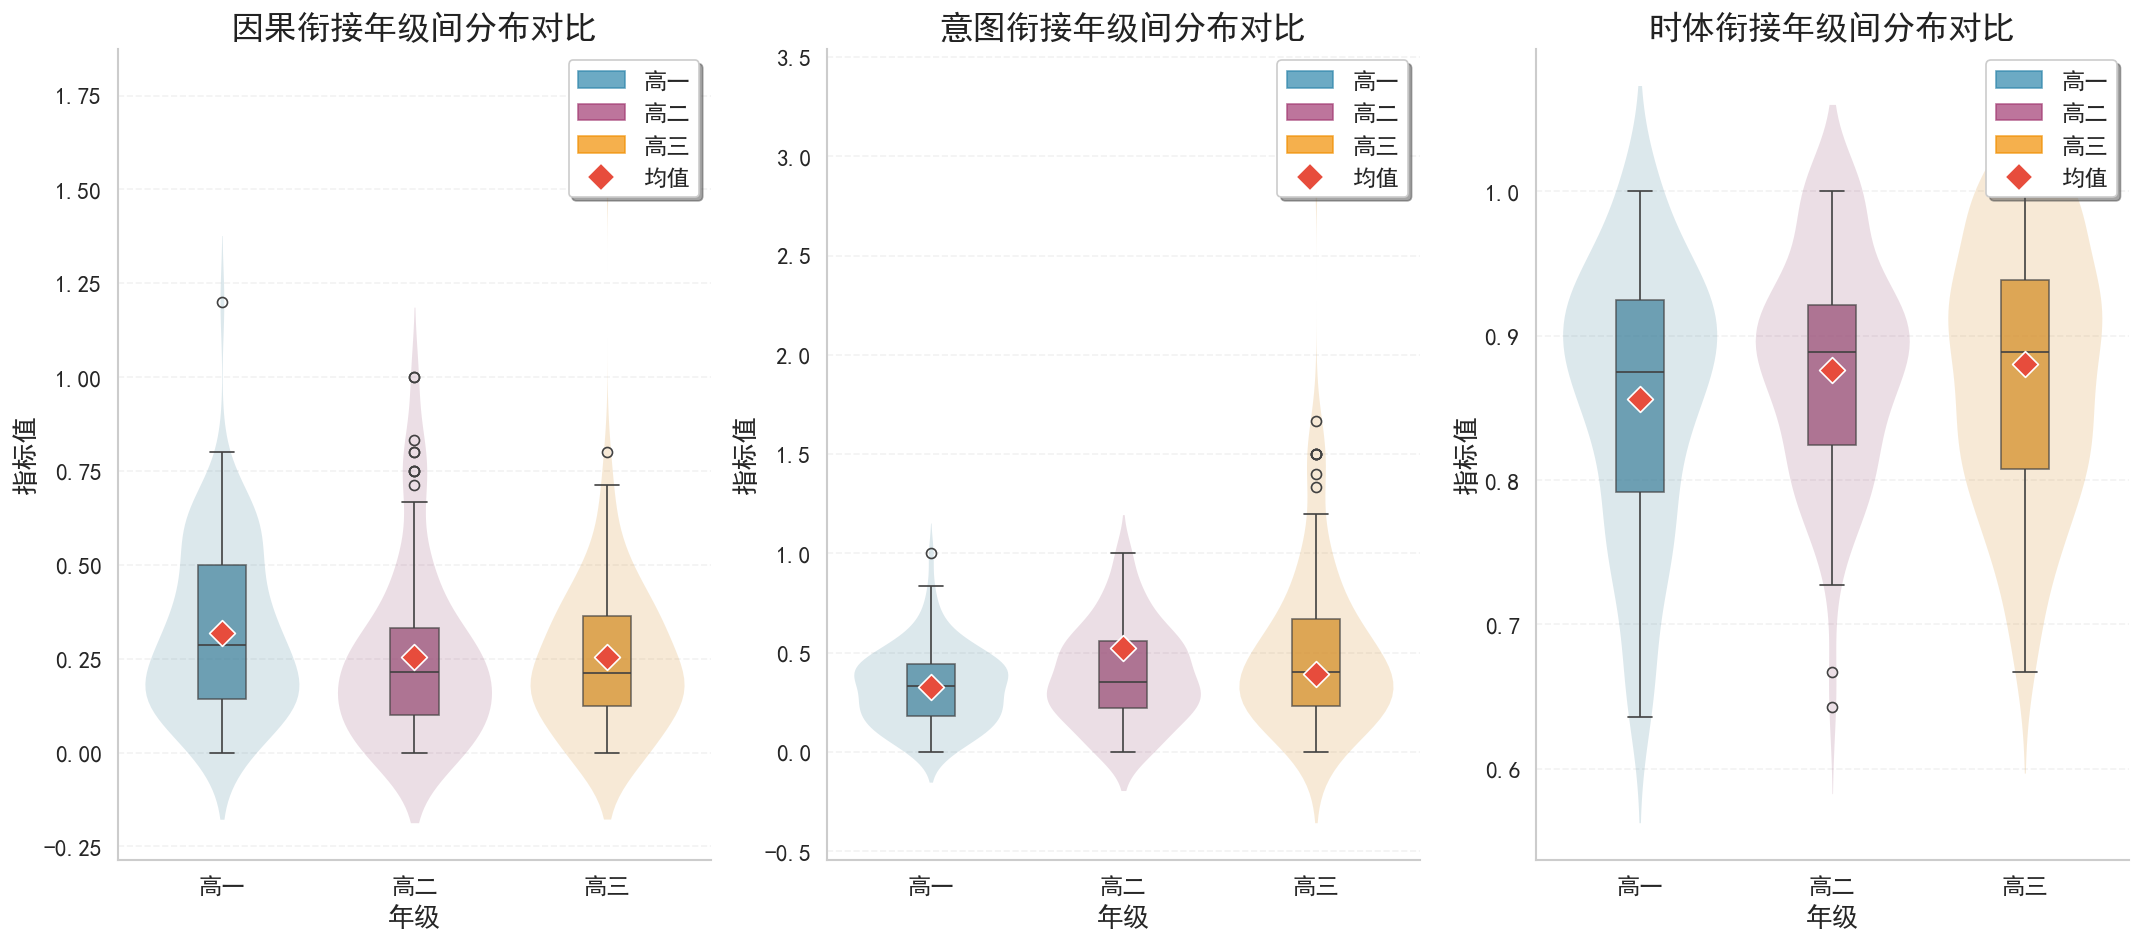

箱线图已保存为: ../res/宏观叙事情境模型箱线图比较.png
生成宏观叙事情境模型变异系数热力图...


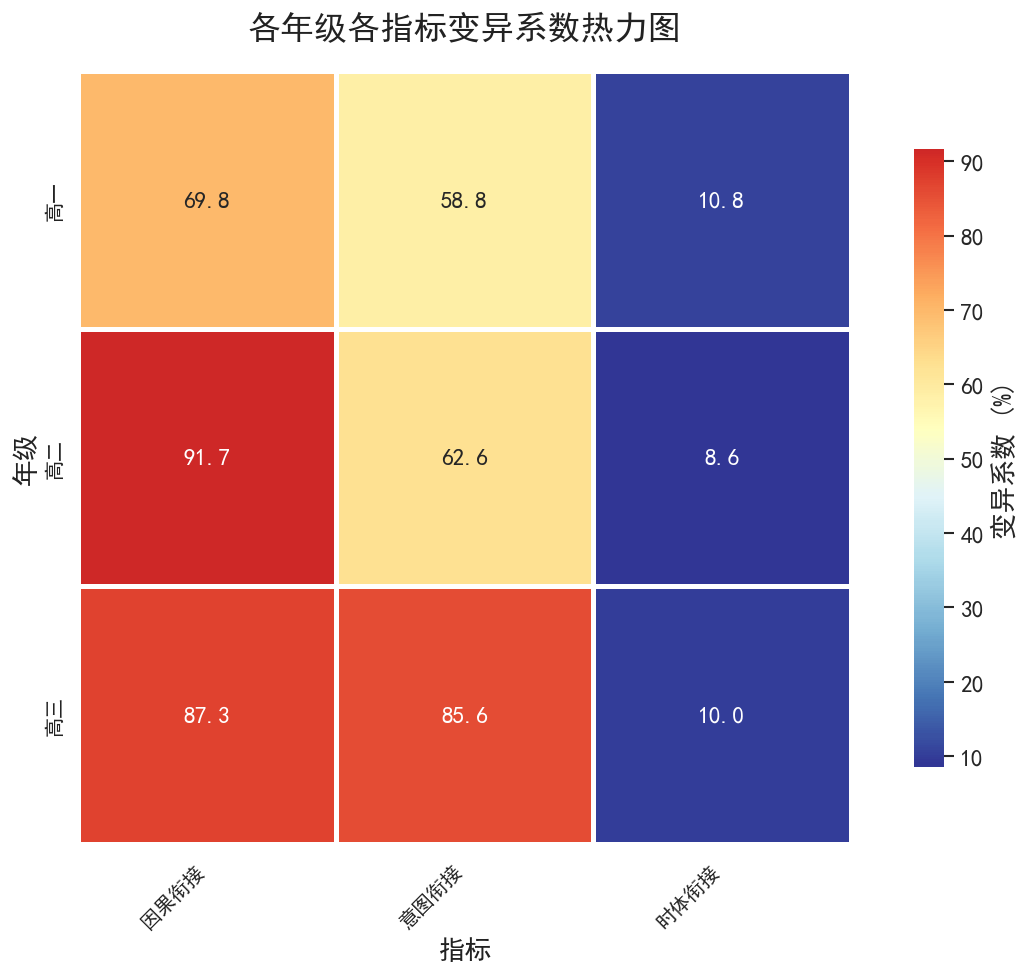

变异系数热力图已保存为: ../res/宏观叙事情境模型变异系数热力图.png
分析结果已保存到：../res/res_v2/宏观叙事-情境模型/分析结果.txt
分析完成！


In [10]:
# 执行描述性统计分析
descriptive_statistics_situation_model(data, grade_groups)

# 创建可视化图表
create_situation_model_visualizations(data, grade_groups)

# 保存分析结果到文件
import sys
from io import StringIO

# 重定向输出到字符串
old_stdout = sys.stdout
result = StringIO()
sys.stdout = result

# 重新执行分析
descriptive_statistics_situation_model(data, grade_groups)

# 恢复标准输出
sys.stdout = old_stdout

# 保存结果到文件
output_path = '../res/res_v2/宏观叙事-情境模型/分析结果.txt'
import os
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, 'w', encoding='utf-8') as f:
    f.write(result.getvalue())

print(f"分析结果已保存到：{output_path}")
print("=" * 80)
print("分析完成！")
print("=" * 80)